# Bayesian mediation analysis in PyMC3

**Author:** [Ben Vincent](https://github.com/drbenvincent)

This notebook outlines how to do a basic [mediation analysis](https://en.wikipedia.org/wiki/Mediation_(statistics)) in PyMC3. The implimentation is based on the paper Bayesian Mediation Analysis by Yuan & MacKinnon (2009). In brief, we want to know if a relationship $x \rightarrow y$ is mediated (wholey or partially) by a mediator $m$. 

The basic approach by Yuan & MacKinnon (2009) is to conduct inference on the parameters of a mediation model:

![Mediation model diagram](figs/mediation_model.png)

$$
m = \text{Normal}(m_{0} + \alpha \cdot x, \sigma_m)
$$

$$
y = \text{Normal}(y_{0} + \beta \cdot m + \tau' \cdot x, \sigma_y)
$$

So we basically calculate $P(\alpha, \beta, \tau', m_0, y_0, \sigma_m, \sigma_y| x, m, y)$.

This requires priors for $\alpha, \beta, \tau', m_0, y_0, \sigma_m, \sigma_y$. The approach taken by Yuan & MacKinnon (2009) is to use very broad (i.e. uninformative priors), but we can obviously try to do better than this if we have domain knowledge.

Note that this model defines a "mediation effect" which is $\theta = \alpha \cdot \beta$. We also have a "direct effect" which is $\tau'$. Depending on whether $\theta = 0$ and/or $\tau'=0$, we can draw various conclusions.

Also, the approach of Yuan & MacKinnon (2009) is very much a 'parameter estimation' approach. More of a hypothesis testing approach, with shift of focus on to Bayes Factors is provided by Nuijten et al (2014).

## Setup
Optional: If you want to use autoformatter, then 

    pip install nb-black

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd

# plotting
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})

import pymc3 as pm
import arviz as az

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.8


## Define options

In [3]:
SEED = 123

n_samples = 2_000

sample_options = {
    "tune": 2_000,
    "draws": n_samples,
    "chains": 2,
    "cores": 2,
    "nuts_kwargs": {"target_accept": 0.95},
    "random_seed": SEED,
}

np.random.seed(SEED)

## Create synthetic dataset

In [4]:
N = 50

# define parameters (only used in the context of simulated data)
α, β, τprime, m0, y0, σm, σy = 0.5, 0.6, 0.3, 0.0, 0.0, 0.5, 0.5

params = {"α": α, "β": β, "τprime": τprime}

# calculate the true mediation effect
θ = α * β

In [5]:
def make_data():
    x = np.random.randn(N)
    m = m0 + α * x + (np.random.randn(N) * σm)
    y = y0 + (τprime * x) + (β * m) + (np.random.randn(N) * σy)
    return x, m, y


x, m, y = make_data()

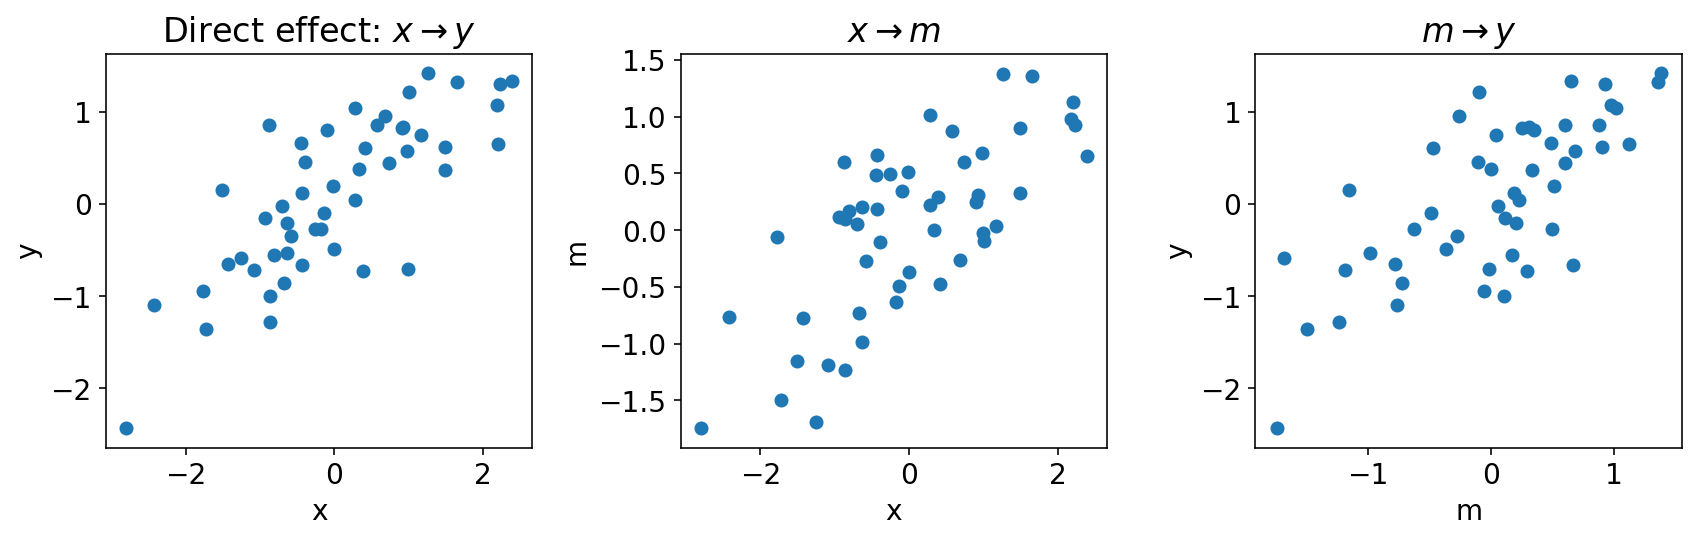

In [6]:
def plot_data(x, m, y):

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].scatter(x, y)
    ax[0].set(xlabel="x", ylabel="y", title=r"Direct effect: $x \rightarrow y$")

    ax[1].scatter(x, m)
    ax[1].set(xlabel="x", ylabel="m", title=r"$x \rightarrow m$")

    ax[2].scatter(m, y)
    ax[2].set(xlabel="m", ylabel="y", title=r"$m \rightarrow y$")

    fig.tight_layout()

    return ax


ax = plot_data(x, m, y)

## Make model

In [7]:
def bayesian_mediation(x, m, y):
    """Conduct simple Bayesian mediation analysis.
    This is an implimentation of Yuan & MacKinnon (2009) in PyMC3.
    Returns the model and the trace."""

    print("WARNING: Priors must be updated to suit your specific data context")

    with pm.Model() as model:
        m0 = pm.Normal("m0", mu=0, sd=10)
        y0 = pm.Normal("y0", mu=0, sd=10)
        α = pm.Normal("α", mu=0, sd=10)
        β = pm.Normal("β", mu=0, sd=10)
        τprime = pm.Normal("τprime", mu=0, sd=10)

        σm = pm.HalfCauchy("σm", 1)
        σy = pm.HalfCauchy("σy", 1)

        m = pm.Normal("m", mu=m0 + α * x, sd=σm, observed=m)
        y = pm.Normal("y", mu=y0 + β * m + τprime * x, sd=σm, observed=y)

        # calculate the "mediated effect"
        θ = pm.Deterministic("θ", α * β)

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [8]:
model, trace = bayesian_mediation(x, m, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σy, σm, τprime, β, α, y0, m0]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:05<00:00, 1464.83draws/s]


## Due diligence

In [9]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m0,0.021,0.076,-0.133,0.157,0.001,0.001,3898.0,1921.0,3915.0,2296.0,1.0
y0,0.066,0.074,-0.071,0.204,0.001,0.001,4071.0,2850.0,4079.0,2930.0,1.0
α,0.462,0.063,0.338,0.580,0.001,0.001,3984.0,3963.0,3977.0,2855.0,1.0
β,0.360,0.145,0.085,0.629,0.003,0.002,2990.0,2990.0,2994.0,2916.0,1.0
τprime,0.389,0.092,0.222,0.570,0.002,0.001,3024.0,2911.0,3043.0,2742.0,1.0
σm,0.528,0.039,0.454,0.599,0.001,0.000,4132.0,4109.0,4129.0,2815.0,1.0
σy,6.124,50.181,0.001,11.337,1.127,0.797,1984.0,1984.0,3572.0,2255.0,1.0
θ,0.166,0.072,0.035,0.309,0.001,0.001,3128.0,3052.0,3133.0,3000.0,1.0


You can inspect the traces using:

```python
az.plot_trace(trace)
```

## Is there a "mediation effect"?
The mediation effect is given by $\theta = \alpha \cdot \beta$. The posterior will tell us our beliefs about the mediation effect given the data. In particular, is it credibly non-zero?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd0068f5d0>],
      dtype=object)

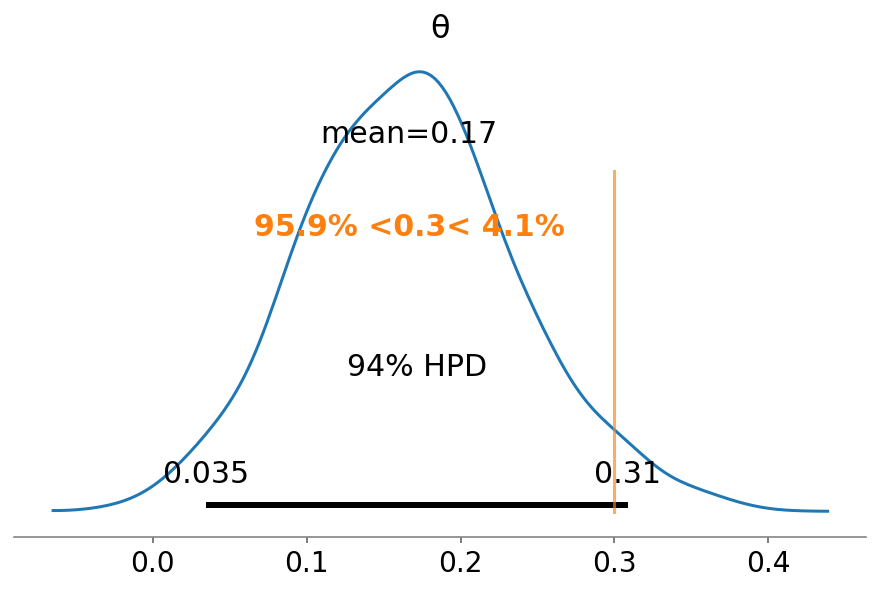

In [10]:
az.plot_posterior(trace, var_names="θ", ref_val=θ)

Either way, we might be interested in the $x \rightarrow m \rightarrow y$ slopes, given by $\alpha$ and $\beta$ respectively.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd17978fd0>],
      dtype=object)

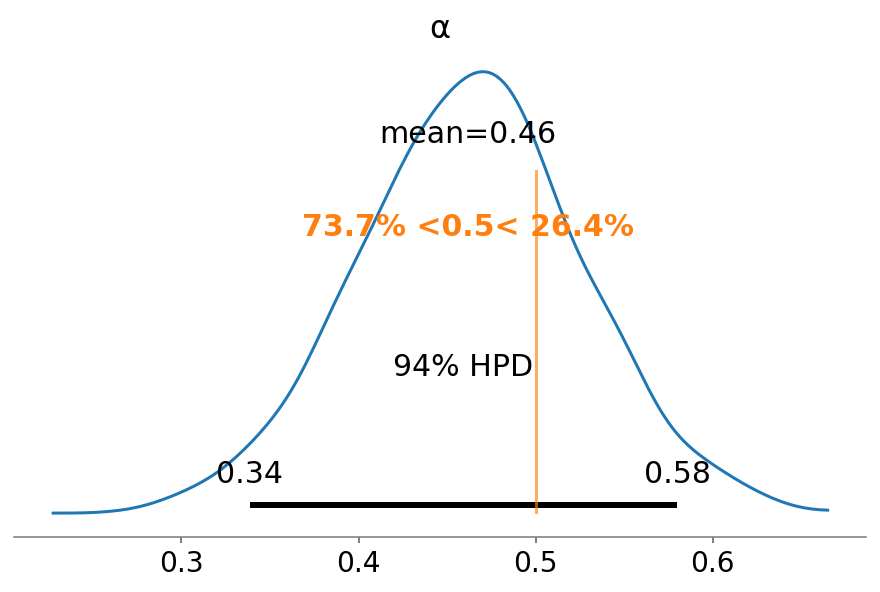

In [11]:
az.plot_posterior(trace, var_names="α", ref_val=α)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd17cbe910>],
      dtype=object)

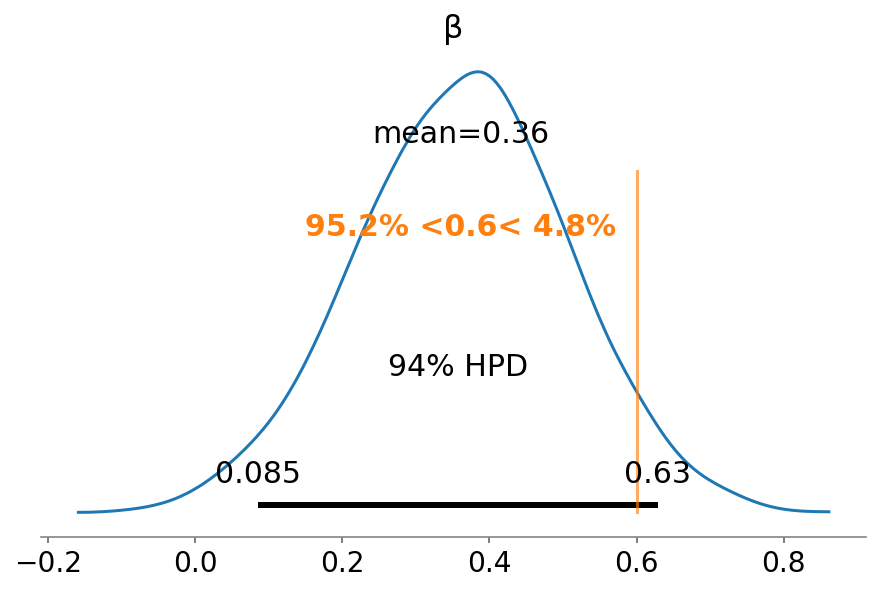

In [12]:
az.plot_posterior(trace, var_names="β", ref_val=β)

## Is there a direct effect $\tau'$ between $x$ and $y$?
The direct effect between $x$ and $y$ is given by $\tau'$. The posterior will tell us our beliefs about it given the data. In particular, is it credibly non-zero?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbce0d1b590>],
      dtype=object)

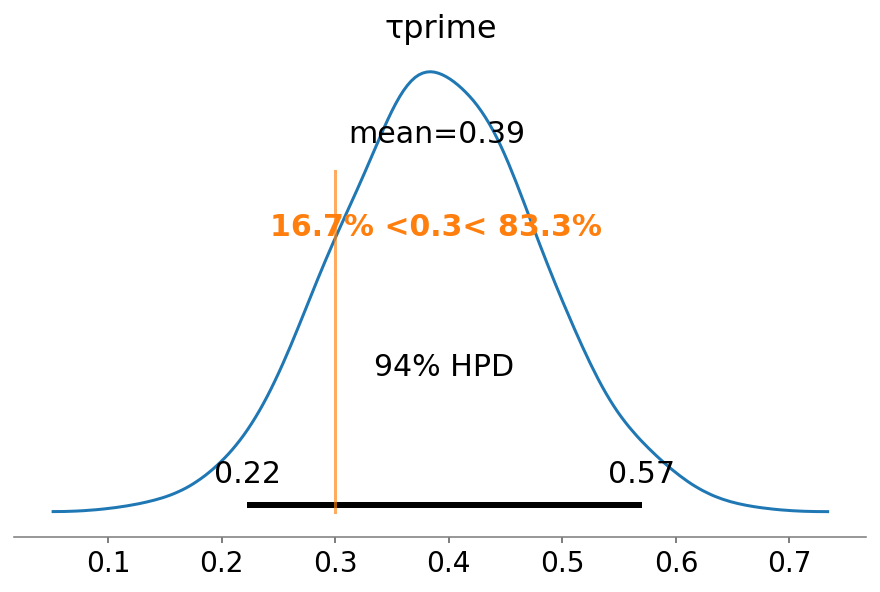

In [13]:
az.plot_posterior(trace, var_names="τprime", ref_val=τprime)

## Conclusions

If:

- $\tau' = 0$ and $\theta \neq 0$, then we have evidence that the effect of $x$ upon $y$ is _fully mediated_ by $m$.
- $\tau' \neq 0$ and $\theta \neq 0$, then we have evidence that the effect of $x$ upon $y$ is _partially mediated_ by $m$.

## For completeness, plot the full set of posteriors

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbce09c8310>,
      dtype=object)

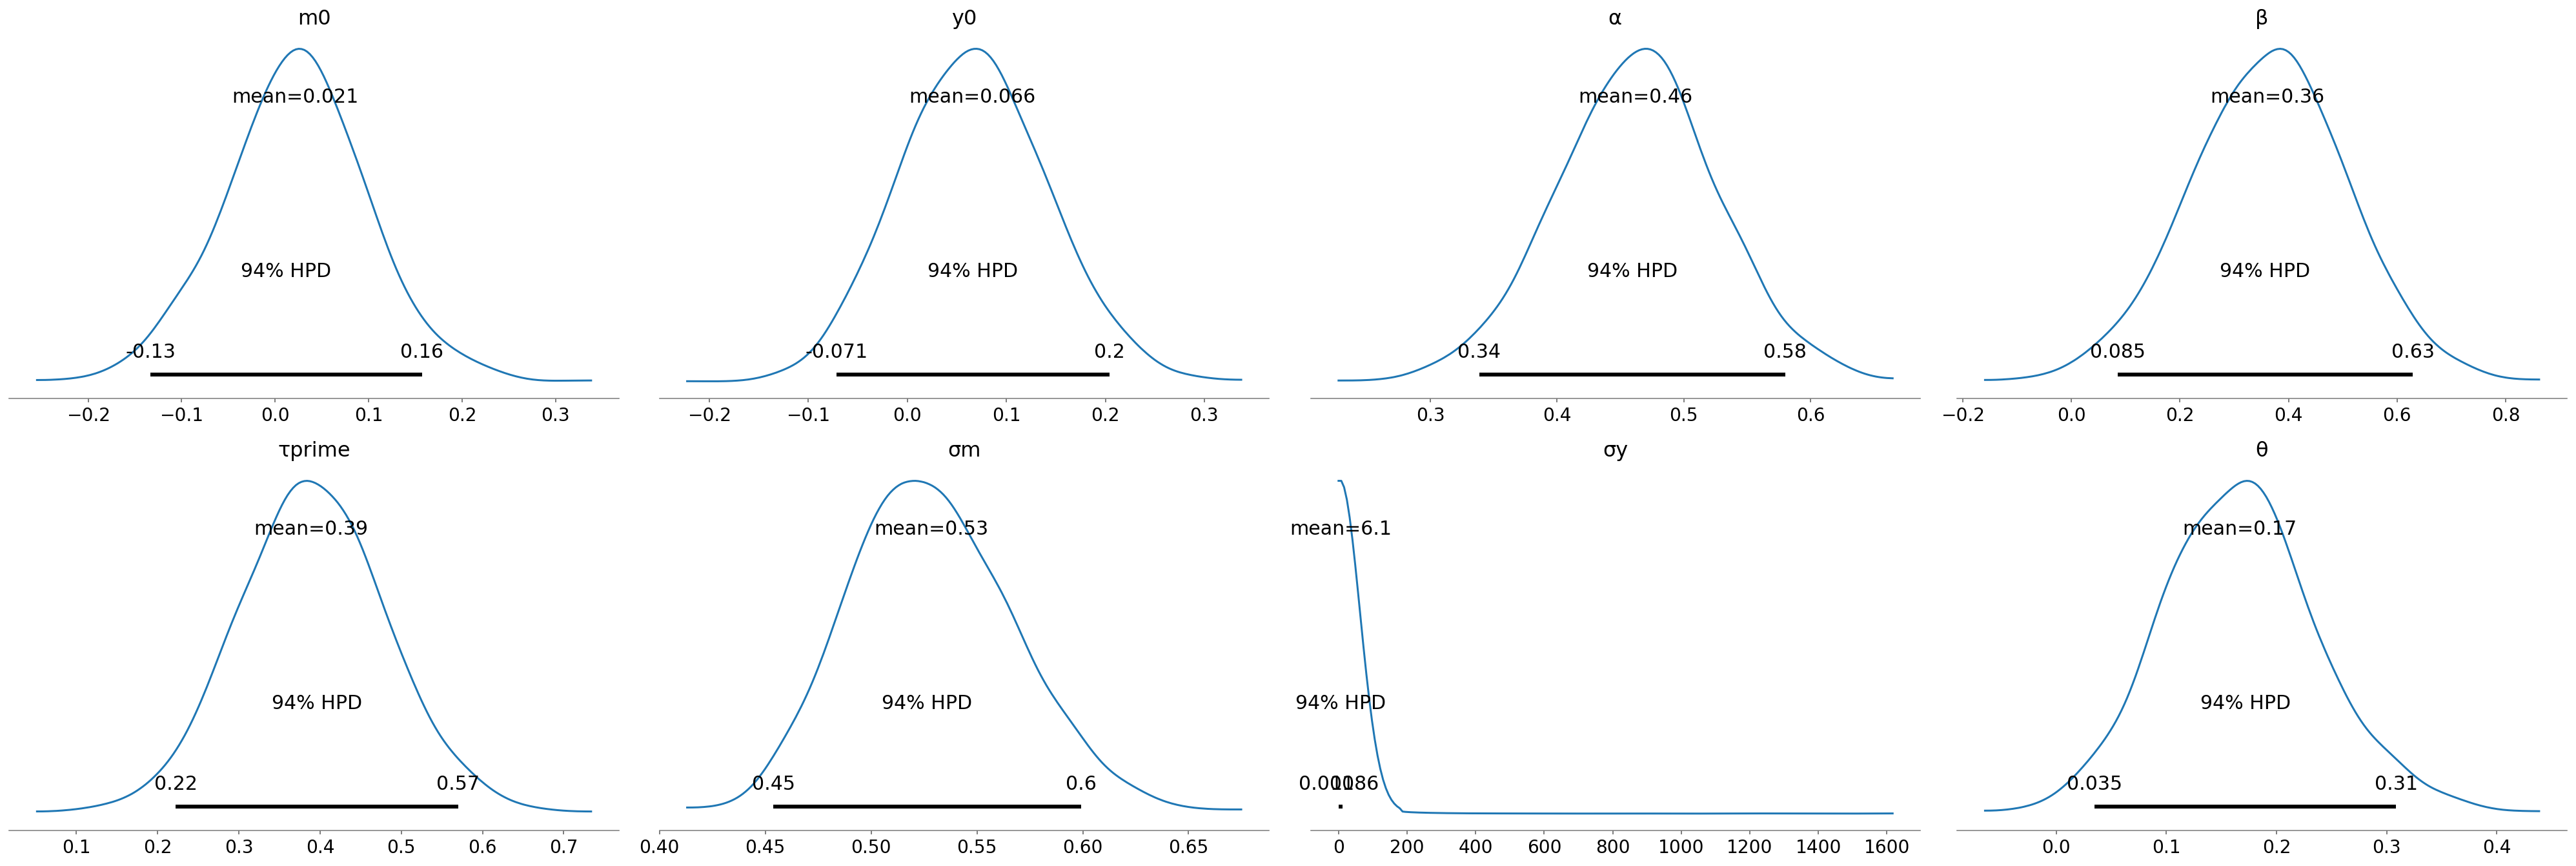

In [14]:
# for completeness, plot the full set of posteriors
az.plot_posterior(trace)

## Posterior predictive checks
As a sanity check, compare the posterior predictions with the observed data.

In [15]:
def posterior_prediction_plot(trace, x, m, y, ax):

    xi = np.linspace(np.min(x), np.max(x), 20)
    mi = np.linspace(np.min(m), np.max(m), 20)

    _m0 = np.expand_dims(trace["m0"], axis=1)
    _y0 = np.expand_dims(trace["y0"], axis=1)
    _α = np.expand_dims(trace["α"], axis=1)
    _β = np.expand_dims(trace["β"], axis=1)
    _τprime = np.expand_dims(trace["τprime"], axis=1)

    # X -> M ====================================================
    mi = _m0 + _α * xi
    region = np.percentile(mi, [2.5, 50, 97.5], axis=0)
    ax[0].fill_between(
        xi, region[0, :], region[2, :], alpha=0.2, edgecolor="w",
    )
    ax[0].plot(xi, region[1, :])
    # plot data
    ax[0].scatter(x, m, c="k")
    ax[0].set(xlabel="x", ylabel="m", title=r"$m = m_0 + \alpha x$")

    # (X, M) -> Y =================================================
    yi = _y0 + _β * mi + _τprime * xi
    ax[1].set(title=r"$y = y_0 + \beta m + \tau' x$")

    return ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcd86c9510>,
      dtype=object)

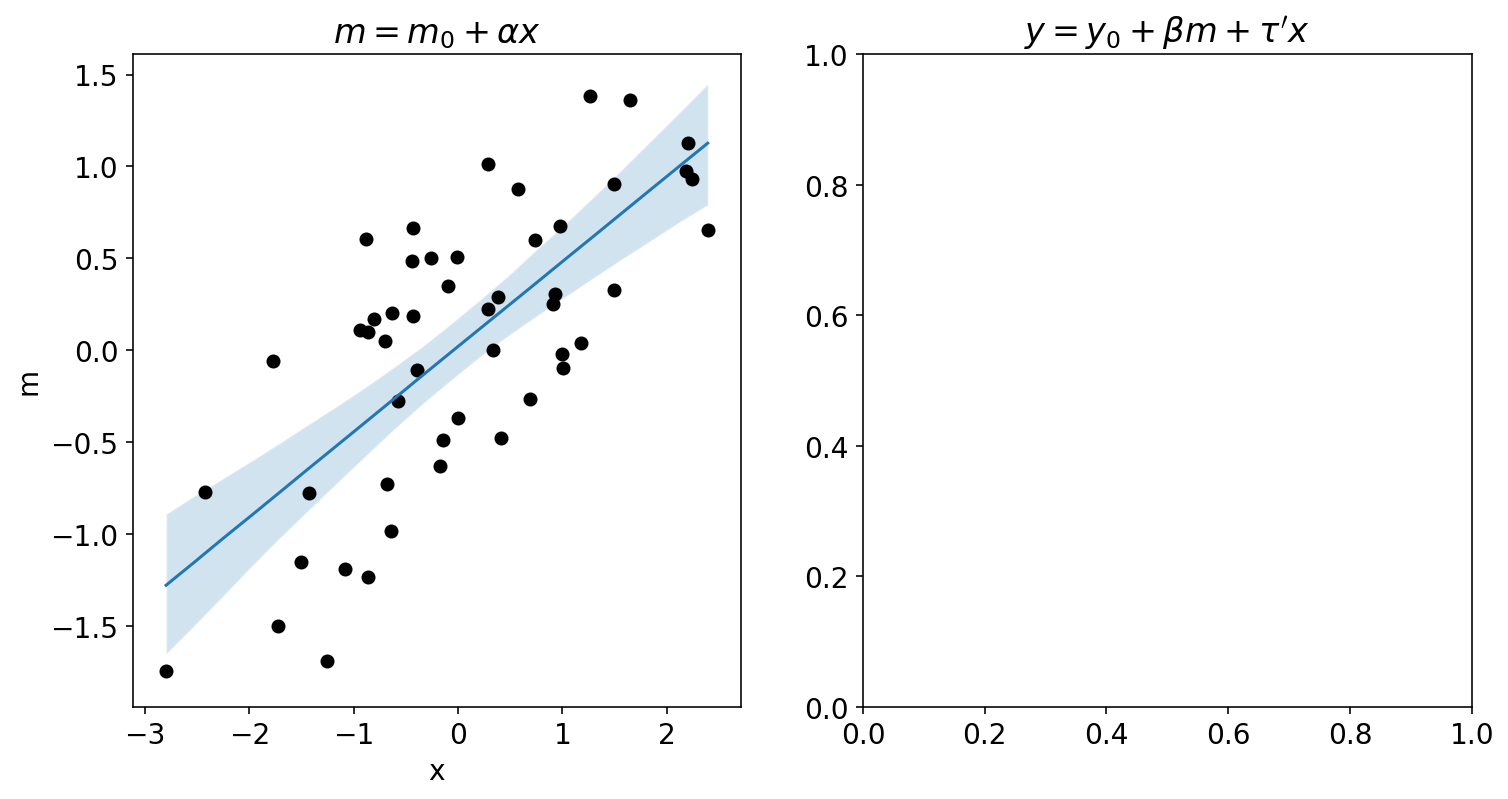

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

posterior_prediction_plot(trace, x, m, y, ax=ax)

# References

Yuan, Y., & MacKinnon, D. P. (2009). Bayesian mediation analysis. Psychological Methods, 14(4), 301–322. http://doi.org/10.1037/a0016972

Nuijten, M. B., Wetzels, R., Matzke, D., Dolan, C. V., & Wagenmakers, E.-J. (2014). A default Bayesian hypothesis test for mediation. Behavior Research Methods, 47(1), 85–97. http://doi.org/10.3758/s13428-014-0470-2